#SVM

In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import yaml
import wandb

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec

In [2]:
import sys
# Import functions from preprocessing module
sys.path.append('..')
from utils.load_data import load_processed_data

## Load data

In [3]:
df = load_processed_data()
train_data = df["train"]
test_data = df["test"]
dev_data = df["dev"]

X_train, y_train = train_data["lemma"], train_data["label"]
X_test, y_test = test_data["lemma"], test_data["label"]
X_dev, y_dev = dev_data["lemma"], dev_data["label"]

Data loaded


##TF-IDF

In [4]:
tfidf_params_list = [
    {'max_features': 3000, 'ngram_range': (1, 1), 'min_df': 5},
    {'max_features': 3000, 'ngram_range': (1, 2), 'min_df': 5},
    {'max_features': 5000, 'ngram_range': (1, 1), 'min_df': 5},
    {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 5},
    {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5},
    {'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 5}
]

In [5]:
print(sys.path)

['/Users/mac/opt/anaconda3/envs/sexism_detection/lib/python39.zip', '/Users/mac/opt/anaconda3/envs/sexism_detection/lib/python3.9', '/Users/mac/opt/anaconda3/envs/sexism_detection/lib/python3.9/lib-dynload', '', '/Users/mac/opt/anaconda3/envs/sexism_detection/lib/python3.9/site-packages', '/Users/mac/opt/anaconda3/envs/sexism_detection/lib/python3.9/site-packages/setuptools/_vendor', '..']


In [6]:
wandb.init(project="online_sexism_detection", name="tfidf_svm")
for tfidf_params in tfidf_params_list:
    vectorizer = TfidfVectorizer(**tfidf_params)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # Train the SVM model
    svm_model = SVC(random_state=42, class_weight='balanced', probability=True)
    svm_model.fit(X_resampled, y_resampled)

    # Make predictions with SVM
    y_pred_svm = svm_model.predict(X_test_tfidf)

    # Evaluate the SVM model
    print("SVM Results:")
    print(confusion_matrix(y_test, y_pred_svm))
    print(classification_report(y_test, y_pred_svm))

    # Log results
    wandb.log({
        'tfidf_params': tfidf_params,
        "f1": f1_score(y_test, y_pred_svm),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_svm),
        "accuracy": accuracy_score(y_test, y_pred_svm),
    })

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: e12409115 (online_sexism_detection). Use `wandb login --relogin` to force relogin


SVM Results:
[[2965   65]
 [ 600  370]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3030
           1       0.85      0.38      0.53       970

    accuracy                           0.83      4000
   macro avg       0.84      0.68      0.71      4000
weighted avg       0.84      0.83      0.81      4000

SVM Results:
[[2948   82]
 [ 574  396]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3030
           1       0.83      0.41      0.55       970

    accuracy                           0.84      4000
   macro avg       0.83      0.69      0.72      4000
weighted avg       0.83      0.84      0.81      4000

SVM Results:
[[2965   65]
 [ 607  363]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3030
           1       0.85      0.37      0.52       970

    accuracy                           0.83      4000
   macro

accuracy,▄█▁█▁▄
balanced_accuracy,▃█▁▆▁▃
f1,▃█▁▆▁▃
accuracy,0.83375
balanced_accuracy,0.6807
f1,0.52803


# Metrics

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3030
           1       0.65      0.66      0.65       970

    accuracy                           0.83      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.83      0.83      0.83      4000



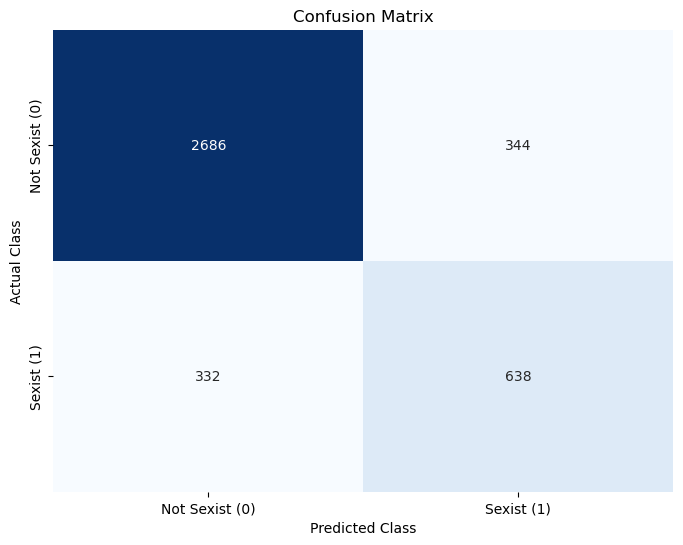

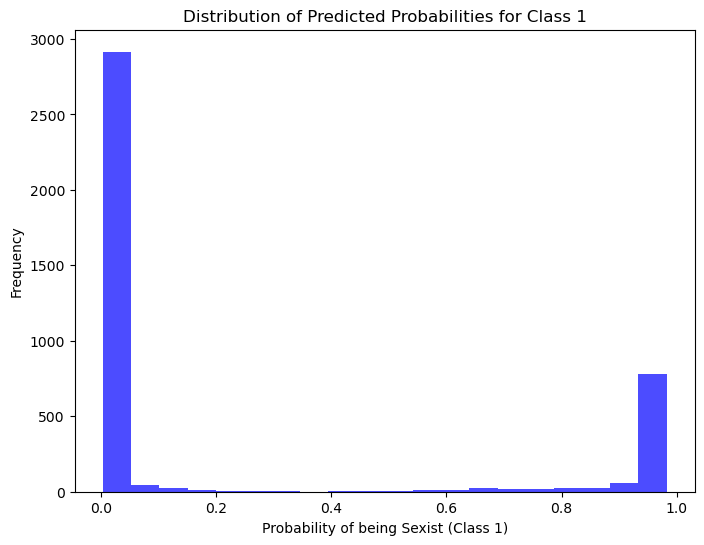

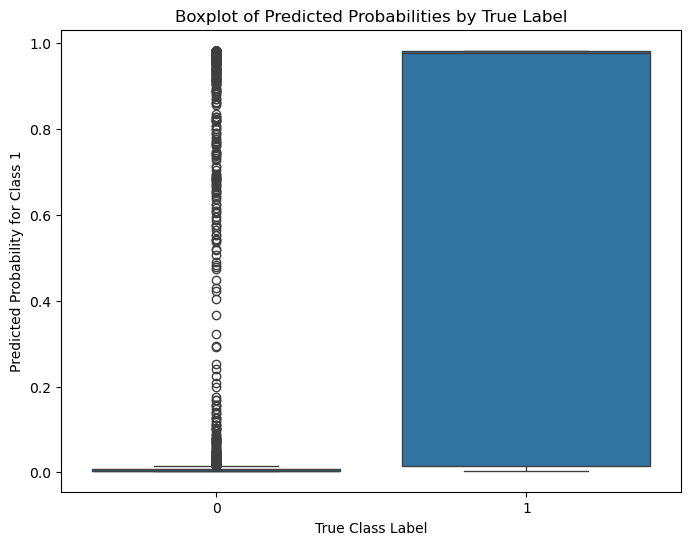

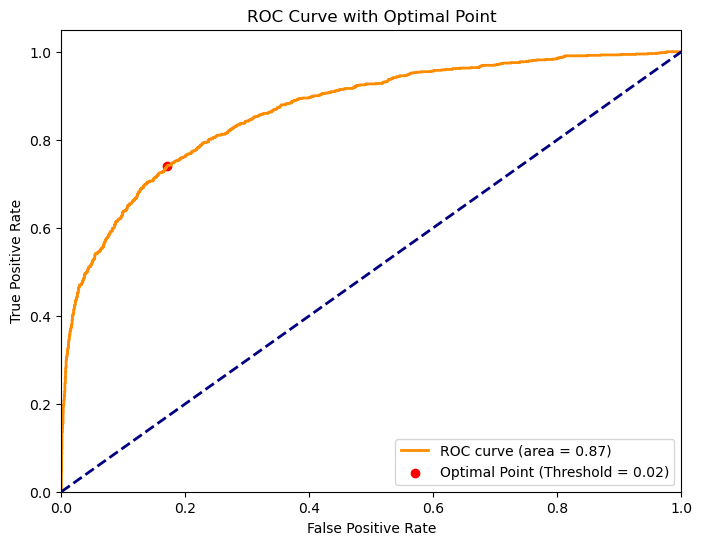

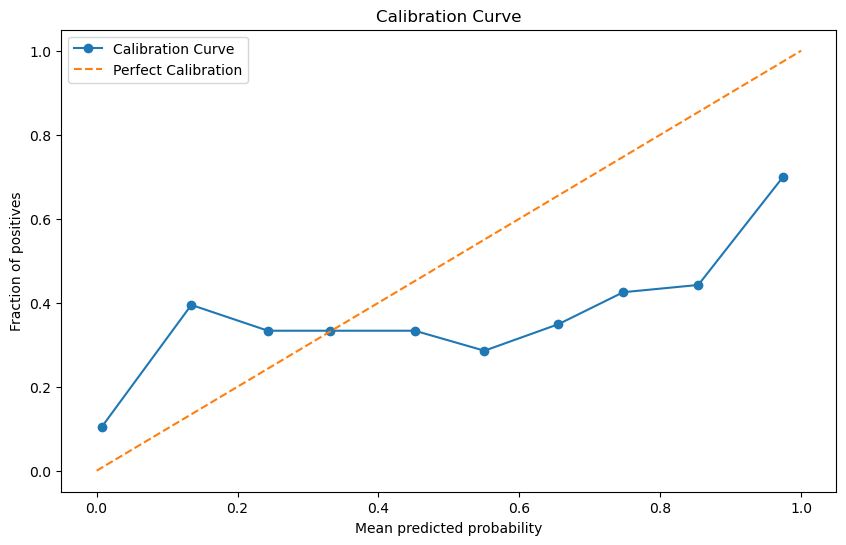

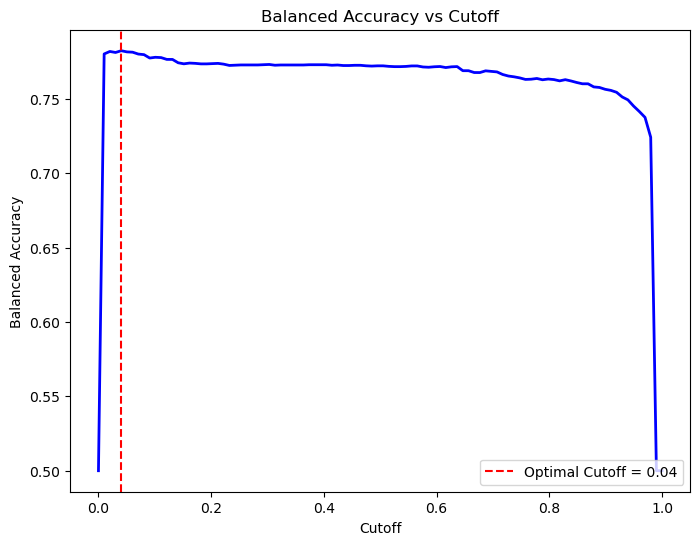

In [1]:
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, classification_report,  roc_curve, auc, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_classification_report(df, label_col='label', pred_col='y_pred'):
    print("Classification Report:")
    print(classification_report(df[label_col], df[pred_col]))


def plot_confusion_matrix(df, label_col='label', pred_col='y_pred', title='Confusion Matrix'):
    cm = confusion_matrix(df[label_col], df[pred_col])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Not Sexist (0)', 'Sexist (1)'], yticklabels=['Not Sexist (0)', 'Sexist (1)'])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.show()

def plot_boxplot_predicted_probabilities(df, label_col='label', prob_col='prob_1', title='Boxplot of Predicted Probabilities by True Label'):
    # the output of this does not make sense to me yet. Has to be reviewed!!
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[label_col], y=df[prob_col])
    plt.xlabel('True Class Label')
    plt.ylabel('Predicted Probability for Class 1')
    plt.title(title)
    plt.show()

def plot_roc_curve_with_optimal_point(df, label_col='label', prob_col='prob_1', title='ROC Curve with Optimal Point'):
    y_true = df[label_col]
    y_prob = df[prob_col]
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(optimal_fpr, optimal_tpr, marker='o', color='red', label=f'Optimal Point (Threshold = {optimal_threshold:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_balanced_accuracy_vs_cutoff(df, label_col='label', prob_col='prob_1', title='Balanced Accuracy vs Cutoff'):
    y_true = df[label_col]
    cutoffs = np.linspace(0, 1, 100)
    balanced_accuracies = []

    for cutoff in cutoffs:
        y_pred = (df[prob_col] >= cutoff).astype(int)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        balanced_accuracies.append(balanced_acc)

    optimal_idx = np.argmax(balanced_accuracies)
    optimal_cutoff = cutoffs[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(cutoffs, balanced_accuracies, color='blue', lw=2)
    plt.axvline(x=optimal_cutoff, color='red', linestyle='--', label=f'Optimal Cutoff = {optimal_cutoff:.2f}')
    plt.xlabel('Cutoff')
    plt.ylabel('Balanced Accuracy')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_calibration_curve(df, label_col='label', prob_col='prob_1', n_bins=10, title='Calibration Curve'):
    y_true = df[label_col]
    y_prob = df[prob_col]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_probability_distribution(df, prob_col_1='prob_1', prob_col_0='prob_0'):
    plt.figure(figsize=(8, 6))
    plt.hist(df[prob_col_1], bins=20, alpha=0.7, color='b')
    plt.xlabel('Probability of being Sexist (Class 1)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for Class 1')
    plt.show()
    # should obviously be exactly inverted, can be used as test
    # plt.figure(figsize=(8, 6))
    # plt.hist(df[prob_col_0], bins=20, alpha=0.7, color='g')
    # plt.xlabel('Probability of not being Sexist (Class 0)')
    # plt.ylabel('Frequency')
    # plt.title('Distribution of Predicted Probabilities for Class 0')
    # plt.show()



if __name__ == '__main__':
    # Testing the functions:
    df_output = pd.read_csv("../data_submission/dl_predictions.csv")
    print_classification_report(df_output)
    plot_confusion_matrix(df_output)
    plot_probability_distribution(df_output)
    plot_boxplot_predicted_probabilities(df_output)
    plot_roc_curve_with_optimal_point(df_output)
    plot_calibration_curve(df_output)
    plot_balanced_accuracy_vs_cutoff(df_output)

In [ ]:
from utils.metrics import plot_confusion_matrix, plot_calibration_curve, plot_probability_distribution, plot_boxplot_predicted_probabilities, plot_balanced_accuracy_vs_cutoff, plot_roc_curve_with_optimal_point, print_classification_report

In [2]:
df_output = pd.read_csv("../data_submission/svm_TFIDF_predictions.csv", index_col=0)
df_output.reset_index(drop=True, inplace=True)
df_output.head(2)

,y_pred,prob_0,prob_1,logit_0,logit_1,label
0,0,0.974648,0.025352,NaN,NaN,0
1,0,0.876454,0.123546,NaN,NaN,0


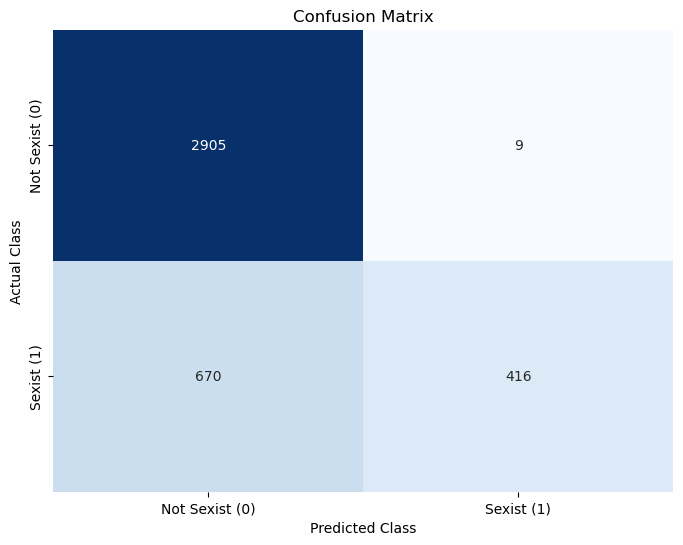

In [3]:
plot_confusion_matrix(df_output)

In [4]:
print_classification_report(df_output)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      2914
           1       0.98      0.38      0.55      1086

    accuracy                           0.83      4000
   macro avg       0.90      0.69      0.72      4000
weighted avg       0.86      0.83      0.80      4000



In [5]:
df_output['y_pred'] = (df_output['prob_1'] > 0.25)

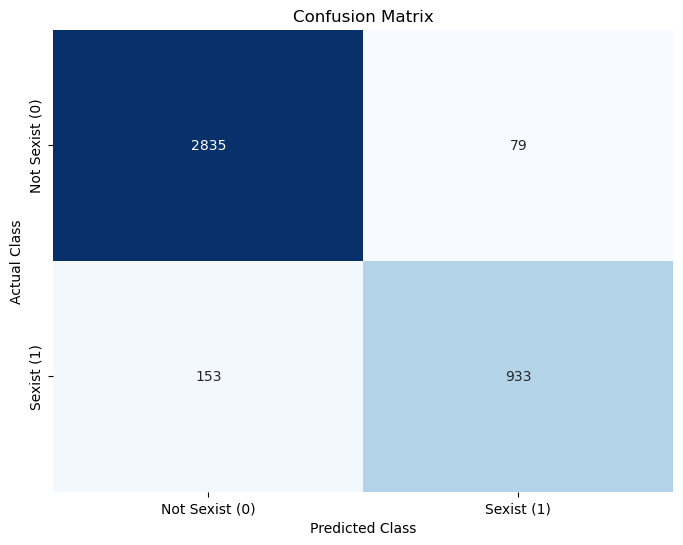

In [6]:
plot_confusion_matrix(df_output)

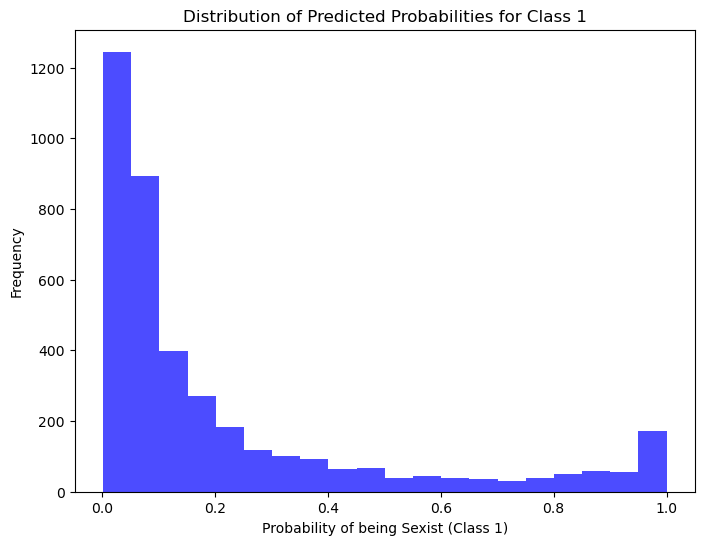

In [7]:
plot_probability_distribution(df_output)

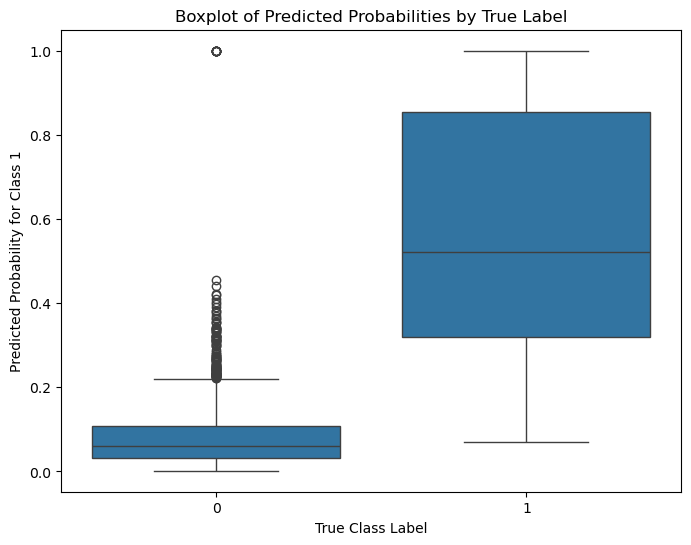

In [8]:
plot_boxplot_predicted_probabilities(df_output)